# TMDB Box Office Prediction (Kaggle competition)

### Problem statement
In this competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. You can collect other publicly available data to use in your model predictions, but in the spirit of this competition, use only data that would have been available before a movie's release.

- Train data: 3000 films
- Test data: 4398 films

Submissions are evaluated on Root-Mean-Squared-Logarithmic-Error (RMSLE) between the predicted value and the actual revenue. Logs are taken to not overweight blockbuster revenue movies.

### Machine learning model
- Gradient Boosting
- LightGBM
- XGBoost
- Model stacking (meta ensembling)

### Result
- The pretictive model produce a **RMSLE score = 1.94524 (top 30% worldwide)**
- Leaderboard: https://www.kaggle.com/c/tmdb-box-office-prediction/leaderboard

### Reference
1. https://www.kaggle.com/c/tmdb-box-office-prediction 
<br>
<br>
<br>

In [311]:
from IPython.display import HTML

display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

# Reference: http://blog.nextgenetics.net/?e=102
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide the codes"></form>''')


In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
plt.style.use('seaborn-muted')
sns.set_style('whitegrid')

import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (11, 8)
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## Load data

The "train.csv" and "test.csv" datasets were provided. In order to cover some missing values in the original data, the "imdb_features.csv" dataset was obtained using web scrappoing with *Beautiful Soup* to extract useful information from IMDb website,using "imdb_id" provided by the original train and test data.

In [231]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
imdb_bs = pd.read_csv('imdb_features.csv')

After loading the data, let's take a look at the data structures and summary of the data.

First the training dataset.

In [232]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [233]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

***
- Looks like the train data has 3000 rows of record. 
- Some of the features are numeric, but also many of them are strings and other data structures such as dictionaries. 
- More than half of the features contains missing values (NaN or Null object).
***

Then, what about test dataset?

In [234]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

***
- The test data has 4398 rows of record, even more than the training data! 
- This indicates some challenges to training the model w/ limited data, which could **lead to a model which failed to generalize well.** 
- Again, it can be seen that there are some features including missing values (NaN or Null object).
***

The data extracted from IMDb database are shown below.

In [235]:
imdb_bs.head()

,imdb_id,budget_imdb,rating_imdb,votes_imdb,director_imdb,runtime_imdb
0,tt2637294,14000000,5.1,34363,Steve Pink,93.0
1,tt0368933,40000000,5.8,67428,Garry Marshall,113.0
2,tt2582802,3300000,8.5,611499,Damien Chazelle,106.0
3,tt1821480,-1,8.1,51646,Sujoy Ghosh,122.0
4,tt1380152,-1,5.8,284,Jong-seok Yoon,118.0


In [236]:
imdb_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7398 entries, 0 to 7397
Data columns (total 6 columns):
imdb_id          7398 non-null object
budget_imdb      7398 non-null int64
rating_imdb      7398 non-null float64
votes_imdb       7398 non-null int64
director_imdb    6862 non-null object
runtime_imdb     6978 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 346.9+ KB


***
- Still some missing entities in some features, such as in "director" and "runtime". 
***

## Data cleaning & Exploratory analysis

First, I need to merge the imdb_bs dataset with the train and test datasets.

In [237]:
train = pd.merge(train, imdb_bs, how='left', on='imdb_id')
test = pd.merge(test, imdb_bs, how='left', on='imdb_id')

Now, need to define a function to help extract useful information from the compound structure of strings. <br>
Since useful information is mostly stored as dictionaries in some columns, e.g. "belongs_to_collection", "genres", "Keywords	", "cast"", "crew", etc. 

In [238]:
def extract_text(series, label=True):
    symbol = "[{}]:'"
    if type(series)==str:
        temp = [x.split("': ") for x in [z.strip(symbol) for z in series.split(', ')]]
        return [x[1].lstrip("'/") for x in temp if x[0]==label]
    else: None

In [239]:
for col in ['belongs_to_collection','genres','production_companies','Keywords']:
    train[col] = train[col].apply(lambda x: extract_text(x, 'name'))
    test[col] = test[col].apply(lambda x: extract_text(x, 'name'))

The data becomes more usable in columns "belongs_to_collection", "genres", "production_companies", and "Keywords".

In [240]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,title,Keywords,cast,crew,revenue,budget_imdb,rating_imdb,votes_imdb,director_imdb,runtime_imdb
0,1,[Hot Tub Time Machine Collection],14000000,[Comedy],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,14000000,5.1,34363,Steve Pink,93.0
1,2,[The Princess Diaries Collection],40000000,"[Comedy, Drama, Family, Romance]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,40000000,5.8,67428,Garry Marshall,113.0
2,3,None,3300000,[Drama],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,Whiplash,"[jazz, obsession, conservatory, music teacher,...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,3300000,8.5,611499,Damien Chazelle,106.0
3,4,None,1200000,"[Thriller, Drama]",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,Kahaani,"[mystery, bollywood, police corruption, crime,...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,-1,8.1,51646,Sujoy Ghosh,122.0
4,5,None,0,"[Action, Thriller]",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,Marine Boy,None,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,-1,5.8,284,Jong-seok Yoon,118.0


***
After extracting useful information from from the compound structure of strings, now we need to prepare to **remove the unwanted characters**, such as punctuation and stopwords, etc.
***

In [241]:
import string
import nltk
from itertools import chain

Build a few more functions to help clean up punctuations and stopwors in English.

In [242]:
print('Punctuation such as:', string.punctuation)

Punctuation such as: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [243]:
def remove_punc(text):
    text_rmpunc = ''.join([char for char in text if char not in string.punctuation])
    return text_rmpunc

stopword = nltk.corpus.stopwords.words('english')
def remove_stopword(text):
    text_rmstpwd = [word for word in text if word not in stopword]
    return text_rmstpwd

Build a function to help re-organize the content extracted from the original dictionary format.

In [244]:
def get_dummy_dict_col(df, col):
    if type(df[col][0])==list:
        preset_col = list(set(chain.from_iterable(df[col].fillna(''))))
    else:
        preset_col = list(set(chain(df[col].fillna(''))))
    df_out = pd.DataFrame(data=np.zeros((len(df), len(preset_col)), dtype='float16'), columns=preset_col)
    
    for i in range(len(df)):
        col_list = df.loc[i, col]
        df_out.loc[i, col_list] = 1
    df_out = df_out.add_prefix(str(col)+'_').fillna(0).astype('int8')
    return df_out

### 1. Movie budget

A movie's "budget" is the first thing pops into my mind that could be reflected in its revenue. Let's look at how "budget" influence the movie revenue.

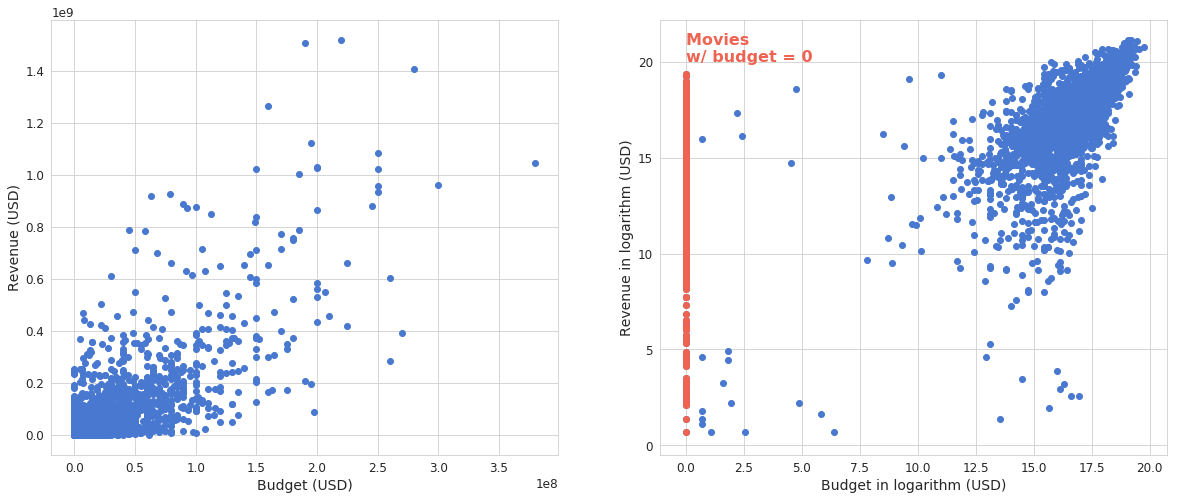

In [245]:
fig, axs = plt.subplots(1,2,figsize=(20,8))
axs[0].scatter(train['budget'], train['revenue'])
axs[1].scatter(np.log1p(train['budget']), np.log1p(train['revenue']))
axs[1].scatter(np.log1p(train.loc[train['budget']==0,'budget']), 
               np.log1p(train.loc[train['budget']==0,'revenue']), c='#EE6352')
axs[0].set_xlabel('Budget (USD)')
axs[0].set_ylabel('Revenue (USD)')
axs[1].set_xlabel('Budget in logarithm (USD)')
axs[1].set_ylabel('Revenue in logarithm (USD)')
axs[1].text(0,20,'Movies \nw/ budget = 0', fontsize=16, color='#EE6352', weight='bold')
plt.show()

***
- It is clear that amount of budget is **directly proportional** to the amount of revenue.
- Unfortunately, they do not have a simple linear relationship (otherwise the world would be much easier to undertand).
- They positive correlation can be visualized clearer by tranforming both features into logarithm scale, as shown in the plots on the righ-hand side. However, there are a lot of noise in the trend.
- There are also many data points which movie budget is 0. This could be due to that the number has never been officially disclosed for those films. 
***

Based on the observation, I would like to create log-scaled "revenue" and "budget", and also the ratio of budget to runtime.

In [246]:
train['log_revenue'] = np.log1p(train['revenue'])

for df in [train, test]:
    df['log_budget'] = np.log1p(df['budget'])
    df['budget_to_runtime'] = df['budget']/df['runtime']

### 2. Movie collection

Now, let's take a look at the stats in whether a movie is part of a collection.

In [247]:
for df in [train, test]:
    df['is_collection'] = np.where(df['belongs_to_collection'].isna(),0,1)
    df.drop('belongs_to_collection', axis=1, inplace=True)

In [248]:
collection_train = get_dummy_dict_col(train, 'is_collection')
collection_test = get_dummy_dict_col(test, 'is_collection')

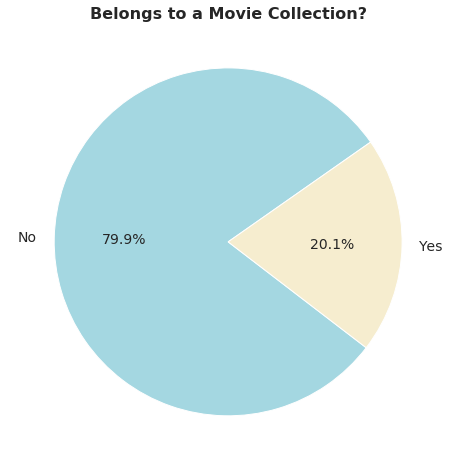

In [249]:
plt.pie(train['is_collection'].value_counts(), labels=['No','Yes'],
        colors=['#a4d7e1','#f6edcf'], autopct='%1.1f%%',
        startangle=35, textprops={'fontsize':14})
plt.title('Belongs to a Movie Collection?', fontsize=16, weight='bold')
plt.show()

***
- In the train dataset, there are 1/4 of the movies are part of a collection.
***

In [250]:
collection_common = list(set(collection_train.columns) & set(collection_test.columns))
collection_train = collection_train[collection_common]
collection_test = collection_test[collection_common]

In [251]:
def get_revenue_stats(df, dummy_feat, method='mean'):
    df2 = pd.concat([df['revenue'], dummy_feat], axis=1)
    dummy_feat_df = pd.DataFrame()
    for col in dummy_feat.columns:
        mask = dummy_feat.loc[:, col].apply(bool)
        dummy_feat_df[col] = df2.loc[mask, ['revenue']].agg(method)
    dummy_feat_df = dummy_feat_df.T.sort_values(by='revenue',ascending=False)
    return dummy_feat_df

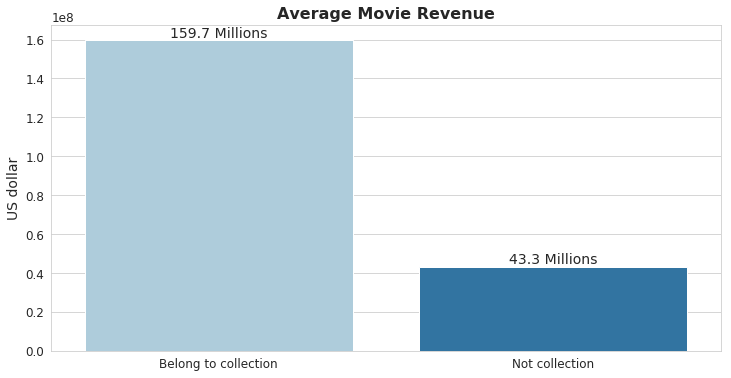

In [252]:
collection_train_df = get_revenue_stats(train, collection_train)

x = collection_train_df.index
y = collection_train_df['revenue']
plt.figure(figsize=(12,6))
ax = sns.barplot(x=x, y=y, palette=sns.color_palette('Paired'))

for n, (label, _y) in enumerate(zip(x, y)):
    ax.annotate(
        '{:.1f} Millions'.format(_y/1e6),
        xy=(n, _y),
        ha='center',va='center',
        xytext=(0,7),
        textcoords='offset points',
        fontsize=14
    )

plt.title('Average Movie Revenue', fontsize=16, weight='bold')
plt.xticks([0,1],['Belong to collection', 'Not collection'])
plt.ylabel('US dollar')
plt.show()

***
- If a movie is part of a collection, it in average creates almost 4x revenue compared to movies that isn't.
- This could be an useful information for predicting film revenue (assuming the prequels also generated good revenues).
***

### 3. Movie keywords

Let's now check about "Keywords," which may carry useful information about the stories in movies and potentially affect revnues.

In [253]:
for df in [train, test]:
    df['Keywords'] = df['Keywords'].fillna('').apply(lambda x: remove_stopword(x))

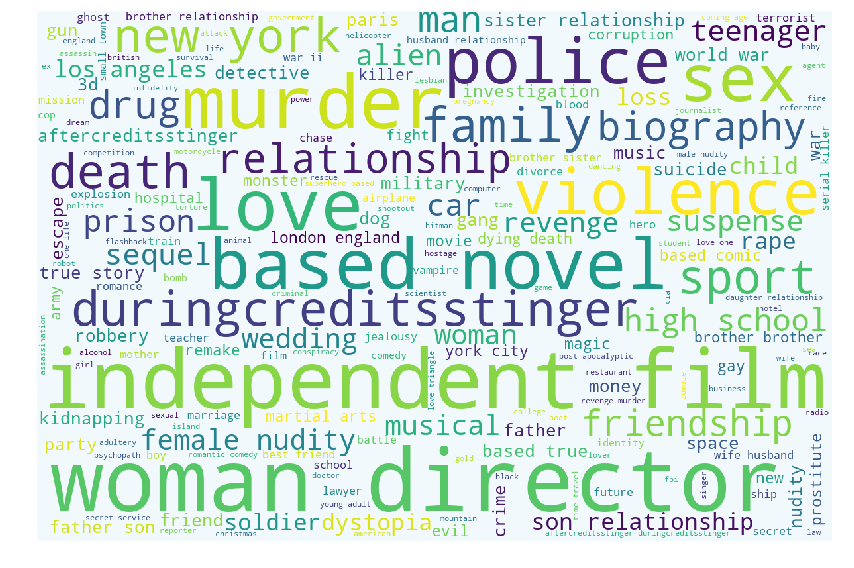

In [254]:
from wordcloud import WordCloud

kywd_pool = ' '.join(sum(train['Keywords'],[]))
wordcloud = WordCloud(width = 1200, height = 800, 
                      background_color ='#F2F9FC', 
                      min_font_size = 10).generate(kywd_pool) 
                      
plt.figure(figsize = (12, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout() 

In [255]:
keyword_train = get_dummy_dict_col(train, 'Keywords')
keyword_test = get_dummy_dict_col(test, 'Keywords')

In [256]:
keyword_common = list(set(keyword_train.columns) & set(keyword_test.columns))
keyword_train = keyword_train[keyword_common]
keyword_test = keyword_test[keyword_common]

train = pd.concat([train, keyword_train], axis=1)
test = pd.concat([test, keyword_test], axis=1)

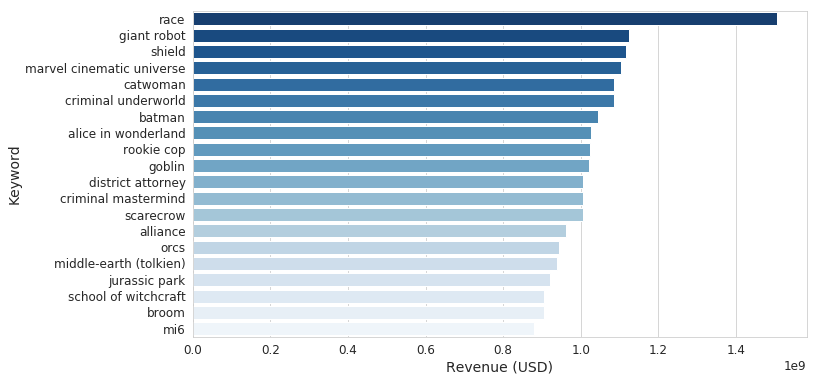

In [257]:
keyword_train_df = get_revenue_stats(train, keyword_train)[:20]

plt.figure(figsize=(11,6))
g = sns.barplot(x='revenue', y=[name[9:] for name in keyword_train_df.index], data=keyword_train_df,
                palette='Blues_r')
plt.xlabel('Revenue (USD)')
plt.ylabel('Keyword')
plt.show()

***
- As seen from the word cloud, the popular keywords are ***"woman director", "independent film", "based on novel", "murder", "violence", "love", "sex", ...... etc.***
- On the other hand, the keywords that generate the most revenues are **"race", "giant robot", "marvel", "criminal underworld", "catwoman","batman", etc.**
- I found "giant robot" located in the 2nd place very interesting.
***

In [276]:
def top_col(df, top=len(df), skip=0):
    top = min(top, len(df)-skip)
    return list(df.sum().sort_values(ascending=False).index[skip:skip+top])

In [258]:
keyword_keep = top_col(pd.concat([keyword_train, keyword_test], axis=0),5)
keyword_train_drop = list(set(keyword_train.columns) - set(keyword_keep))
keyword_test_drop = list(set(keyword_test.columns) - set(keyword_keep))  

train.drop(keyword_train_drop, axis=1, inplace=True)
test.drop(keyword_test_drop, axis=1, inplace=True)

### 4. Movie genres

Another interesting feature besides "Keywords" is the "genres" of the movies.

In [259]:
for df in [train, test]:
    df['genres'] = df['genres'].apply(lambda x: x if x else ['NotAvailable'])
    df['genres'] = df['genres'].apply(lambda x: [elem.lower() for elem in x])

In [260]:
genre_train = get_dummy_dict_col(train, 'genres')
genre_test = get_dummy_dict_col(test, 'genres')

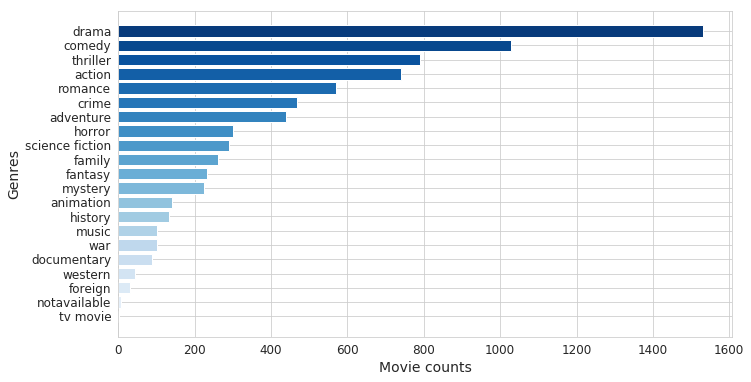

In [261]:
genre_train_temp = genre_train.sum().sort_values()
plt.figure(figsize=(11,6))
plt.barh([name[7:] for name in genre_train_temp.index], genre_train_temp.values, 
         color=sns.color_palette('Blues',len(genre_train_temp)))

plt.xlabel('Movie counts')
plt.ylabel('Genres')
plt.show()

***
- The top 5 genres are **1) Drama, 2) Comedy, 3) Thriller, 4) Action, and 5) Romance**.
***

In [262]:
genre_common = list(set(genre_train.columns) & set(genre_test.columns))
genre_train = genre_train[genre_common]
genre_test = genre_test[genre_common]

train = pd.concat([train, genre_train], axis=1)
test = pd.concat([test, genre_test], axis=1)

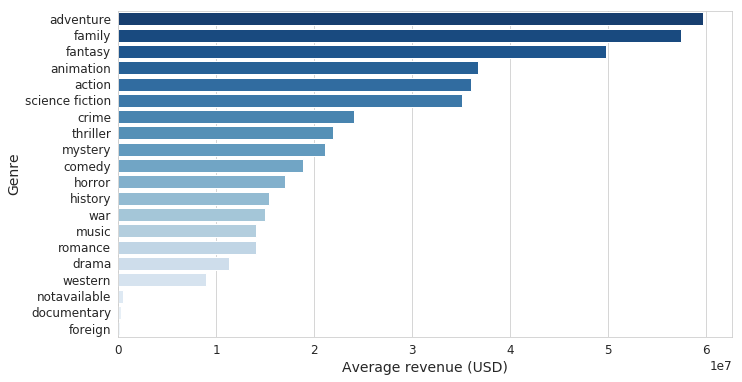

In [263]:
genre_train_df = get_revenue_stats(train, genre_train, 'median')

plt.figure(figsize=(11,6))
g = sns.barplot(x='revenue', y=[name[7:] for name in genre_train_df.index], data=genre_train_df, 
               palette='Blues_r')
plt.xlabel('Average revenue (USD)')
plt.ylabel('Genre')
plt.show()

***
- On the other hand, the top 5 genres associated with high revenues are **1) Adventure, 2) Family, 3) Fantasy, 4) Animation, 5) Action.**
- And the least popular genres include **Documentary** and **Foreign films** (not very surprising).
- It is interesting to see that only **Action** overlaps between the top 5 frequent and top 5 high-revenue genres.
- On the other hand, if we extend the list to top 10 genres, the 2 lists are actually not that different.
- **Animation** actually is doing a good job on blockbuster revenues!
***

In [264]:
genre_keep = top_col(pd.concat([genre_train, genre_test], axis=0),10)
genre_train_drop = list(set(genre_train.columns) - set(genre_keep))
genre_test_drop = list(set(genre_test.columns) - set(genre_keep))  

train.drop(genre_train_drop, axis=1, inplace=True)
test.drop(genre_test_drop, axis=1, inplace=True)

### 5. Movie release date

Another important feature in the movie is the "release date".<br> Let's break it down to year, month, and day of week to see if there is any interesting pattern.

In [265]:
train['release_date'] = train['release_date'].apply(lambda x: x[:-2]+'20'+x[-2:] if int(x[-2:])<18 else x[:-2]+'19'+x[-2:])
train['release_date'] = pd.to_datetime(train['release_date'])
train['release_year'] = train['release_date'].dt.year
train['release_month'] = train['release_date'].dt.month
train['release_dow'] = train['release_date'].dt.dayofweek
train.drop('release_date', axis=1, inplace=True)

In [266]:
test.loc[test['release_date'].isna(), 'release_date'] = '1/5/00'  ## based on IMDB data
test['release_date'] = test['release_date'].apply(lambda x: x[:-2]+'20'+x[-2:] if int(x[-2:])<18 else x[:-2]+'19'+x[-2:])
test['release_date'] = pd.to_datetime(test['release_date'])
test['release_year'] = test['release_date'].dt.year
test['release_month'] = test['release_date'].dt.month
test['release_dow'] = test['release_date'].dt.dayofweek
test.drop('release_date', axis=1, inplace=True)

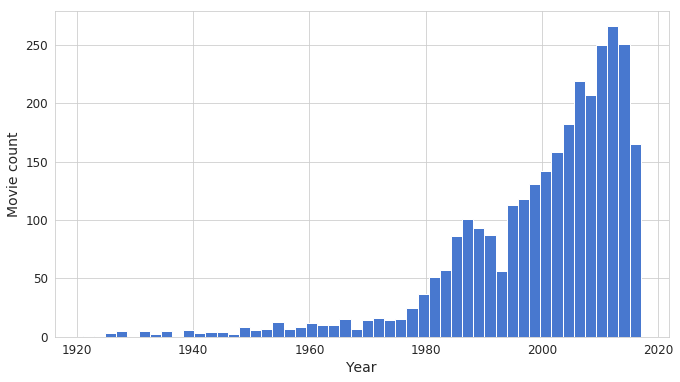

In [267]:
plt.figure(figsize=(11,6))
plt.hist(train['release_year'], bins=50)
plt.xlabel('Year')
plt.ylabel('Movie count')
plt.show()

***
- The movie production count is **increasing** over the years.
***

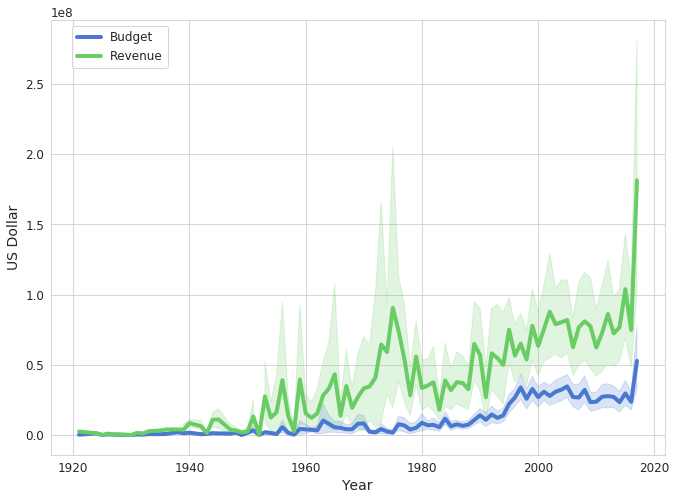

In [268]:
sns.lineplot(x='release_year', y='budget', data=train, lw=4, label='Budget')
sns.lineplot(x='release_year', y='revenue', data=train, lw=4, label='Revenue')
plt.xlabel('Year')
plt.ylabel('US Dollar')
plt.legend(bbox_to_anchor=[0.2,1], fontsize=12)
plt.show()

***
- The general trend for the movie budget is also **increasing** with released year, as well as the revenue.
***

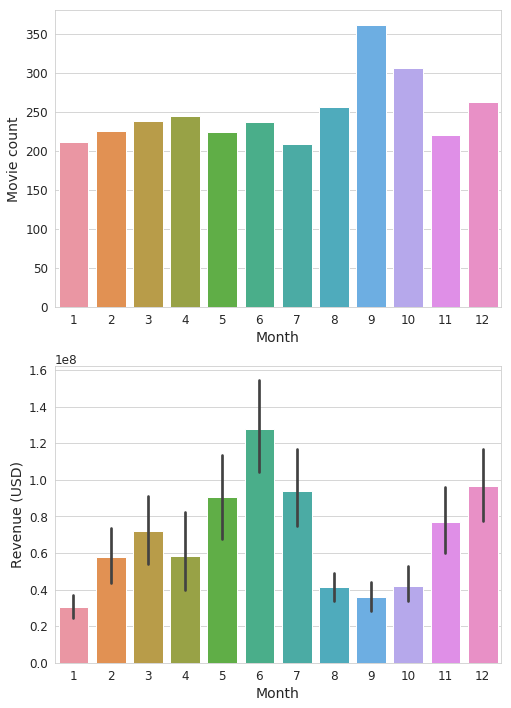

In [269]:
release_month = train['release_month'].value_counts()

figs, axes = plt.subplots(2,1, figsize=(8,12))
sns.barplot(release_month.index, release_month, ax=axes[0])
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Movie count')

sns.barplot(x='release_month', y='revenue', data=train, ax=axes[1])
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Revenue (USD)')

plt.show()

***
- Movie release during summer (**June**, July and May) and end of the year (**December**) have in general have higher revenues.
- This makes sense because people tend to spend more time out during summer, and also the end of year is the holiday season, which is also a good time to see movies with family. 
***

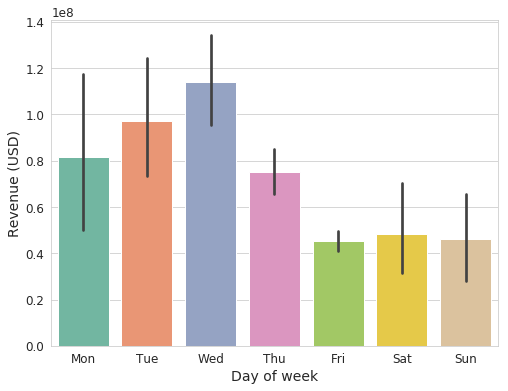

In [270]:
plt.figure(figsize=(8,6))
sns.barplot(x='release_dow', y='revenue', data=train, palette='Set2')
plt.xlabel('Day of week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Revenue (USD)')
plt.show()

***
- Movies that relased in early days of a week seems to generate more revenue than after Friday. 
- The best day to release a movie is **Wednesday**.
***

### 6. Movie runtime

Another interesting feature is the "runtime". I have always felt that the movies nowadays are much longer than the ones I had in my childwood.<br> Let's see if this is confirmed in the general data.

In [271]:
train.loc[train['runtime'].isna(),['runtime','runtime_imdb']]

,runtime,runtime_imdb
1335,NaN,130.0
2302,NaN,NaN


In [272]:
test.loc[test['runtime'].isna(),['runtime','runtime_imdb']]

,runtime,runtime_imdb
243,NaN,93.0
1489,NaN,91.0
1632,NaN,NaN
3817,NaN,90.0


***
- There are a few missing values in "runtime" for both train and test datasets.
***

In [273]:
train.loc[train['runtime'].isna(),'runtime'] = train.loc[train['runtime'].isna(),'runtime_imdb']
test.loc[test['runtime'].isna(),'runtime'] = test.loc[test['runtime'].isna(),'runtime_imdb']

***
- I am going to fill the missiing runtime values from the available IMDB data.
- For the other missing runtime, I am going to use imputation by **replacing them with the mean runtime of all films producded within 1 years**.
***

In [274]:
runtime_missing_year = train.loc[(train['runtime'].isna()) | (train['runtime']==0),'release_year'].tolist() + \
                       test.loc[(test['runtime'].isna()) | (test['runtime']==0),'release_year'].tolist() 

runtime_dict = {}

for yr in runtime_missing_year:
    temp = train.loc[train['release_year'].isin([yr-1, yr, yr+1]), 'runtime']
    runtime_dict[yr] = temp[temp>0].mean()

for df in [train, test]:
    df.loc[(df['runtime'].isna()) | (df['runtime']==0),'runtime'] = \
            df.loc[(df['runtime'].isna()) | (df['runtime']==0),'release_year'].apply(runtime_dict.get)

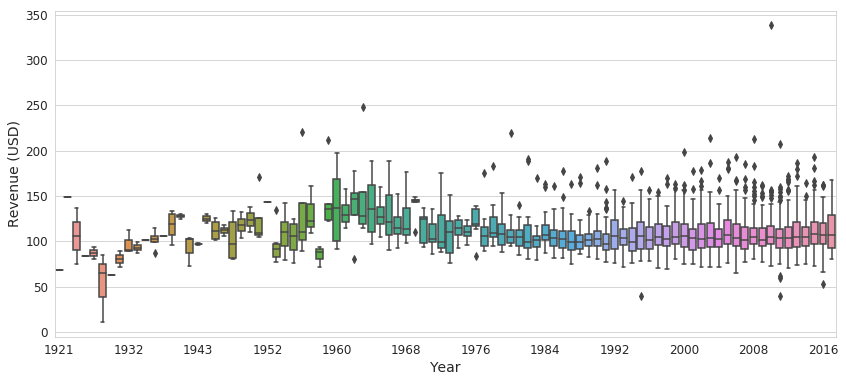

In [275]:
plt.figure(figsize=(14,6))
g = sns.boxplot(x='release_year', y='runtime', data=train)
g.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: g.get_xticklabels()[x].get_text() if x%8==0 else None))
plt.xlabel('Year')
plt.ylabel('Revenue (USD)')
plt.show()

***
- Interestingly, the median movie "runtime" indeed **doubled from about 1920s to 1960s** (~60 min -> 140 min).
- The peak happend around mid 1960s. 
- However, after 1970s the movie runtime actually tended to decrease and stablized around 110-120 min.
- I was born in late 1980s, so **the feeling of movies runtime increased over the years seems simply due to fluctuations**. (Movies produced after 1990s do have wider variation compared to those released in early years)
***

Feature engineering on "title", "tagline", and "overview" to generate their word counts.

In [39]:
for col in ['title','tagline','overview']:
    train['wordcount_'+col] = train[col].fillna('').apply(lambda x: len(x.split()))
    train.drop(col,axis=1,inplace=True)
    test['wordcount_'+col] = test[col].fillna('').apply(lambda x: len(x.split()))
    test.drop(col,axis=1,inplace=True)

### 7. Production country

What about the production country of a movie?

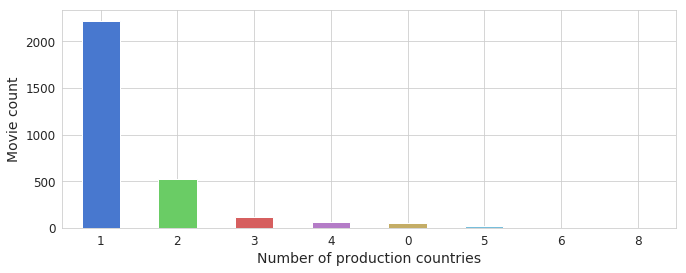

In [40]:
plt.figure(figsize=(11,4))
train['production_countries'].apply(lambda x: extract_text(x, 'name')).fillna('')\
                             .apply(lambda x: len(x)).value_counts().plot.bar(rot=0)
plt.xlabel('Number of production countries')
plt.ylabel('Movie count')
plt.show()

***
- Data shows that there are **more than 2/3 of the movies in the train dataset has only 1 production country**.
- More than 90% has less than 2 production countries. 
- It seems like this feature may not contrain much of information for prediction revenue.
***

In [41]:
train['production_countries'] = train['production_countries'].apply(lambda x: extract_text(x, 'name'))
test['production_countries'] = test['production_countries'].apply(lambda x: extract_text(x, 'name'))

In [42]:
for df in [train, test]:
    df['production_countries'] = df['production_countries'].apply(lambda x: x if x else ['NotAvailable'])

In [43]:
prod_ctry_train = get_dummy_dict_col(train, 'production_countries')
prod_ctry_test = get_dummy_dict_col(test, 'production_countries')

In [44]:
prod_ctry_common = list(set(prod_ctry_train.columns) & set(prod_ctry_test.columns))
prod_ctry_train = prod_ctry_train[prod_ctry_common]
prod_ctry_test = prod_ctry_test[prod_ctry_common]

train = pd.concat([train, prod_ctry_train], axis=1)
test = pd.concat([test, prod_ctry_test], axis=1)

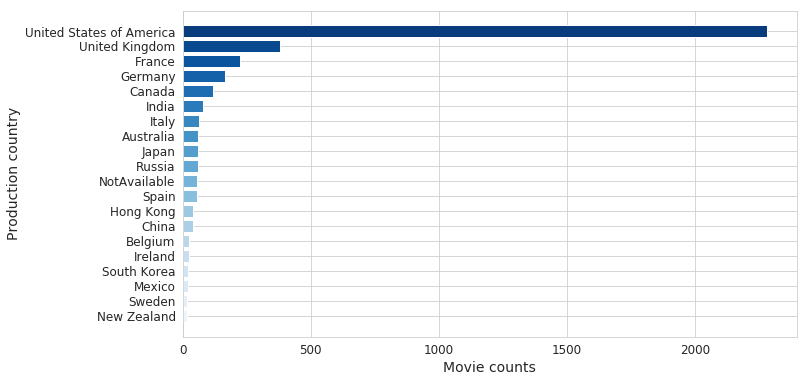

In [46]:
prod_city_temp = prod_ctry_train.sum().sort_values()[-20:]

plt.figure(figsize=(11,6))
plt.barh([name[21:] for name in prod_city_temp.index], prod_city_temp.values, 
         color=sns.color_palette('Blues',len(prod_city_temp)))

plt.xlabel('Movie counts')
plt.ylabel('Production country')
plt.show()

***
- Here only shows the top 20 on the list.
- The majority of movies have at least one of their production countries with USA.
***

In [47]:
prod_ctry_keep = top_col(pd.concat([prod_ctry_train, prod_ctry_test], axis=0),0)
prod_ctry_train_drop = list(set(prod_ctry_train.columns) - set(prod_ctry_keep))
prod_ctry_test_drop = list(set(prod_ctry_test.columns) - set(prod_ctry_keep))  

train.drop(prod_ctry_train_drop, axis=1, inplace=True)
test.drop(prod_ctry_test_drop, axis=1, inplace=True)

In [48]:
for df in [train, test]:
    df['num_prod_ctry'] = df['production_countries'].fillna('').apply(lambda x: len(x))
    df.drop('production_countries', axis=1, inplace=True)

### 8. Production company

Besides production contries, how about the production company?

In [277]:
for df in [train, test]:
    df['production_companies'] = df['production_companies'].fillna('').apply(lambda x: [name.lower() for name in x])

In [278]:
prod_com_train = get_dummy_dict_col(train, 'production_companies')
prod_com_test = get_dummy_dict_col(test, 'production_companies')

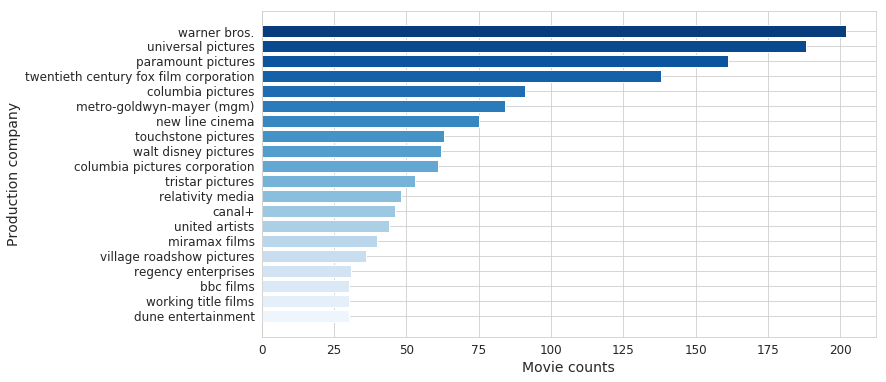

In [279]:
prod_com_temp = prod_com_train.sum().sort_values()[-20:]

plt.figure(figsize=(11,6))
plt.barh([name[21:] for name in prod_com_temp.index], prod_com_temp.values, 
         color=sns.color_palette('Blues',len(prod_com_temp)))

plt.xlabel('Movie counts')
plt.ylabel('Production company')
plt.show()

***
- Here only shows the top 20 production companies on the list.
- From the top few most frequently appeared prodoction companies, we can see **Warner Bros., Universal Pictures, Paramount Pictures, 20th Century Fox, Columbia Pictures, Metro-Goldwyn-Mayer**, etc., which are all very famous film companies that I believe their opening themes may even flash through your mind for a sec.
***

In [280]:
prod_com_common = list(set(prod_com_train.columns) & set(prod_com_test.columns))
prod_com_train = prod_com_train[prod_com_common]
prod_com_test = prod_com_test[prod_com_common]

train = pd.concat([train, prod_com_train], axis=1)
test = pd.concat([test, prod_com_test], axis=1)

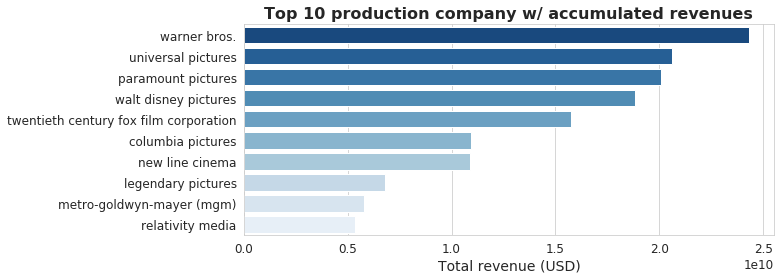

In [281]:
prod_com_train_df = get_revenue_stats(train, prod_com_train, 'sum')[:10]

plt.figure(figsize=(11,4))
sns.barplot(x='revenue', y=[name[21:] for name in prod_com_train_df.index], data=prod_com_train_df,
            palette='Blues_r')

plt.xlabel('Total revenue (USD)')
plt.title('Top 10 production company w/ accumulated revenues', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [282]:
prod_com_keep = top_col(pd.concat([prod_com_train, prod_com_test], axis=0),4)
prod_com_train_drop = list(set(prod_com_train.columns) - set(prod_com_keep))
prod_com_test_drop = list(set(prod_com_test.columns) - set(prod_com_keep))  

train.drop(prod_com_train_drop, axis=1, inplace=True)
test.drop(prod_com_test_drop, axis=1, inplace=True)

### 9. Cast

Now, let's see what kind of information is stored in the "cast" column.

In [283]:
train['cast'][0]

"[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'character

***
- As shown above, there are a lot of information, including 'cast_id', 'character', 'credit_id', 'gender', 'id', 'name', 'order', 'profile_path'. Some of them could be useful, such as **'gender', 'name', and 'order'**.
- It seems like the casts are already sorted in some kind of order, and presumably by the popularity/billed.
***

Here, I am extracting the **number of casts based on genders (male/female/unspecified)**, and also the **total length of cast list** for each movie record.

In [284]:
for df in [train, test]:
    df['cast_gender'] = df['cast'].apply(lambda x: extract_text(x, 'gender'))
    df['gender_0_cast'] = df['cast_gender'].fillna('').apply(lambda x: x.count('0'))
    df['gender_1_cast'] = df['cast_gender'].fillna('').apply(lambda x: x.count('1'))
    df['gender_2_cast'] = df['cast_gender'].fillna('').apply(lambda x: x.count('2'))
    df['cast_name'] = df['cast'].apply(lambda x: extract_text(x, 'name'))
    df['cast_name'] = df['cast_name'].fillna('').apply(lambda x: [elem.lower() for elem in x][:10])
    df['cast_name'] = df['cast_name'].apply(lambda x: [remove_punc(i) for i in x])
    df['len_cast'] = df['cast_name'].fillna('').apply(lambda x: len(x))
    df.drop(['cast','cast_gender'], axis=1, inplace=True)

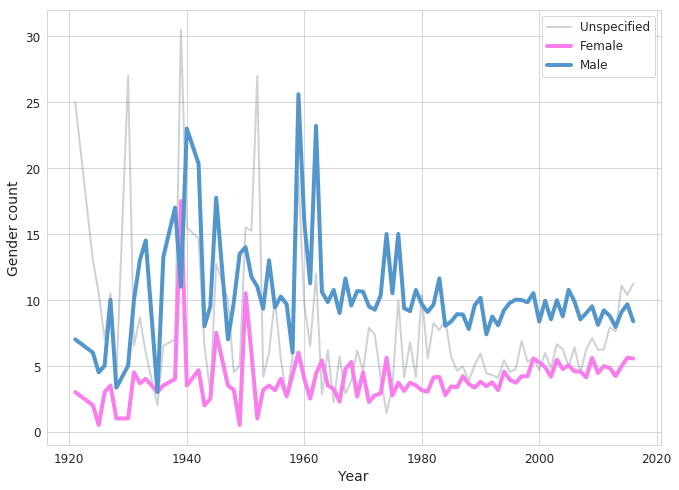

In [285]:
gender_df = train.groupby('release_year', axis=0).agg({'gender_0_cast':'mean',
                                                       'gender_1_cast':'mean',
                                                       'gender_2_cast':'mean',
                                                       'revenue':'mean',
                                                       'budget':'mean'})

sns.lineplot(x=gender_df.index[:-1], y='gender_0_cast', data=gender_df[:-1], lw=2, label='Unspecified', color='#5E6B81', alpha=0.3)
sns.lineplot(x=gender_df.index[:-1], y='gender_1_cast', data=gender_df[:-1], lw=4, label='Female', color='#F97DEC')
sns.lineplot(x=gender_df.index[:-1], y='gender_2_cast', data=gender_df[:-1], lw=4, label='Male', color='#5396CB')
plt.xlabel('Year')
plt.ylabel('Gender count')
plt.legend(fontsize=12)
plt.show()

***
- Number of male casts are almost **always higher** than the number of female casts, assuming unspecified data are evenly distributed in both genders.
***

In [286]:
cast_train = get_dummy_dict_col(train, 'cast_name')
cast_test = get_dummy_dict_col(test, 'cast_name')

I am insterested to see who have been casted the most, and I am expected to see some familiar names.

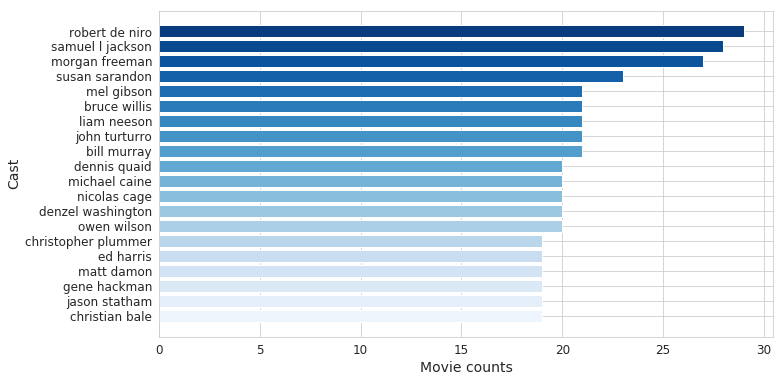

In [287]:
cast_train_temp = cast_train.sum().sort_values()[-20:]

plt.figure(figsize=(11,6))
plt.barh([name[10:] for name in cast_train_temp.index], cast_train_temp.values,
         color=sns.color_palette('Blues',len(cast_train_temp)))
plt.xlabel('Movie counts')
plt.ylabel('Cast')
plt.show()

In [288]:
cast_common = list(set(cast_train.columns) & set(cast_test.columns))
cast_train = cast_train[cast_common]
cast_test = cast_test[cast_common]

train = pd.concat([train, cast_train], axis=1)
test = pd.concat([test, cast_test], axis=1)

In [289]:
cast_keep = top_col(pd.concat([cast_train, cast_test], axis=0),0)
cast_train_drop = list(set(cast_train.columns) - set(cast_keep))
cast_test_drop = list(set(cast_test.columns) - set(cast_keep))  

train.drop(cast_train_drop, axis=1, inplace=True)
test.drop(cast_test_drop, axis=1, inplace=True)

***
- Here only shows the top 20 cast names on the list.
- The cast that starred in the most movies is **Robert De Niro**! He appeared in total 15 movies in this dataset.
- Although casts seem to be a nice feature to suggest movie revenues (we all tend to pick a movie performed by the casts we like), **there is very little amount of samples for each movie star in the dataset.** (The highest count is only 15, ~0.5% in the whole dataset)
- The insufficient examples may not be able to reasonably capture the relationships that exist between the cast and the revenue.
***

### 10. Crew

Let's now explore the list of crews in the dataset.

In [290]:
train['crew'][0]

'[{\'credit_id\': \'59ac067c92514107af02c8c8\', \'department\': \'Directing\', \'gender\': 0, \'id\': 1449071, \'job\': \'First Assistant Director\', \'name\': \'Kelly Cantley\', \'profile_path\': None}, {\'credit_id\': \'52fe4ee7c3a36847f82afad7\', \'department\': \'Directing\', \'gender\': 2, \'id\': 3227, \'job\': \'Director\', \'name\': \'Steve Pink\', \'profile_path\': \'/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg\'}, {\'credit_id\': \'5524ed25c3a3687ded000d88\', \'department\': \'Writing\', \'gender\': 2, \'id\': 347335, \'job\': \'Writer\', \'name\': \'Josh Heald\', \'profile_path\': \'/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg\'}, {\'credit_id\': \'5524ed2d925141720c001128\', \'department\': \'Writing\', \'gender\': 2, \'id\': 347335, \'job\': \'Characters\', \'name\': \'Josh Heald\', \'profile_path\': \'/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg\'}, {\'credit_id\': \'5524ed3d92514166c1004a5d\', \'department\': \'Production\', \'gender\': 2, \'id\': 57822, \'job\': \'Producer\', \'name\': \'Andrew Panay\', \

***
- It's also a messy and long dictionaries of information.
***

Here, I made an assumption that crew members that could make the most impact would be 1) Director, 2) Producer, and 3) Writer. 

In [291]:
for df in [train, test]:
    df['crew_gender'] = df['crew'].apply(lambda x: extract_text(x, 'gender'))
    df['gender_0_crew'] = df['crew_gender'].fillna('').apply(lambda x: x.count('0'))
    df['gender_1_crew'] = df['crew_gender'].fillna('').apply(lambda x: x.count('1'))
    df['gender_2_crew'] = df['crew_gender'].fillna('').apply(lambda x: x.count('2'))
    df['crew_roles'] = df['crew'].apply(lambda x: extract_text(x, 'job'))
    df['len_crew'] = df['crew_roles'].fillna('').apply(lambda x: len(x))
    df['crew_director'] = df['crew'].fillna('').apply(lambda x: dict(list(zip(extract_text(x, 'job'), extract_text(x, 'name')))).get('Director'))
    df['crew_producer'] = df['crew'].fillna('').apply(lambda x: dict(list(zip(extract_text(x, 'job'), extract_text(x, 'name')))).get('Producer'))
    df['crew_writer'] = df['crew'].fillna('').apply(lambda x: dict(list(zip(extract_text(x, 'job'), extract_text(x, 'name')))).get('Writer'))
    df.loc[df['crew_director'].isna(), 'crew_director'] = 'NotAvailable'
    df.loc[df['crew_producer'].isna(), 'crew_producer'] = 'NotAvailable'
    df.loc[df['crew_writer'].isna(), 'crew_writer'] = 'NotAvailable'
    df.drop(['crew','crew_gender','crew_roles'],axis=1, inplace=True)


In [292]:
for df in [train, test]:
    df['crew_director'] = df['crew_director'].apply(lambda x: remove_punc(x.lower()))
    df['crew_producer'] = df['crew_producer'].apply(lambda x: remove_punc(x.lower()))
    df['crew_writer'] = df['crew_writer'].apply(lambda x: remove_punc(x.lower()))
    df['crew_combined'] = [[x,y,z] for x,y,z in zip(df['crew_director'],df['crew_producer'],df['crew_writer'])]

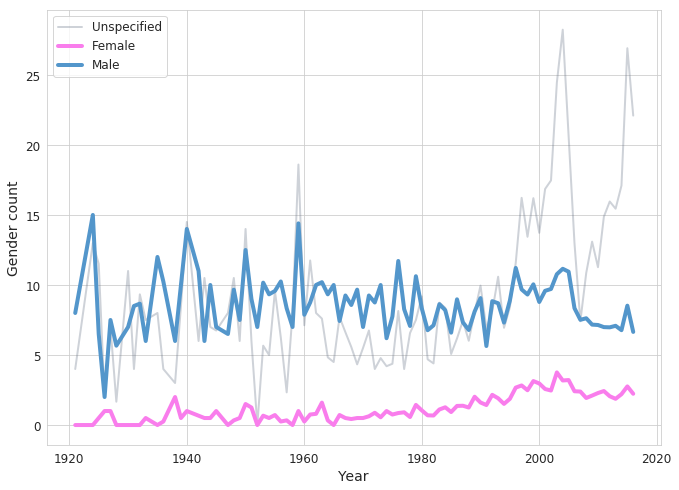

In [293]:
gender_crew_df = train.groupby('release_year', axis=0).agg({'gender_0_crew':'mean',
                                                            'gender_1_crew':'mean',
                                                            'gender_2_crew':'mean',
                                                            'revenue':'mean',
                                                            'budget':'mean'})

g = sns.lineplot(x=gender_crew_df.index[:-1], y='gender_0_crew', data=gender_crew_df[:-1], lw=2, label='Unspecified', color='#5E6B81', alpha=0.3)
g = sns.lineplot(x=gender_crew_df.index[:-1], y='gender_1_crew', data=gender_crew_df[:-1], lw=4, label='Female', color='#F97DEC')
g = sns.lineplot(x=gender_crew_df.index[:-1], y='gender_2_crew', data=gender_crew_df[:-1], lw=4, label='Male', color='#5396CB')

plt.xlabel('Year')
plt.ylabel('Gender count')
plt.legend(fontsize=12)
plt.show()

In [294]:
crew_train = get_dummy_dict_col(train, 'crew_combined')
crew_test = get_dummy_dict_col(test, 'crew_combined')

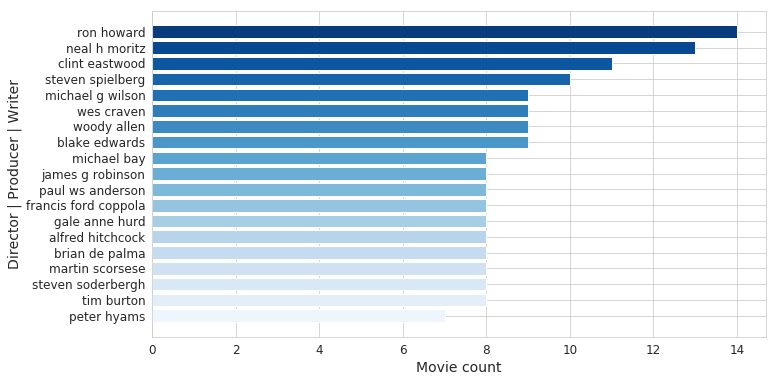

In [295]:
crew_train_temp = crew_train.sum().sort_values()[-20:-1]

plt.figure(figsize=(11,6))
plt.barh([name[14:] for name in crew_train_temp.index], crew_train_temp.values, 
         color=sns.color_palette('Blues',len(crew_train_temp)))

plt.xlabel('Movie count')
plt.ylabel('Director | Producer | Writer')
plt.show()

***
- Here only shows the top 20 crew names on the list.
- The top few people are all big names.
- However, this also shows similar concern as in cast data, which insufficient examples may not be very helpful in model training.
***

The major crew members (Director, Producer, and Writer) and the corresponding movie revenues.

In [296]:
crew_common = list(set(crew_train.columns) & set(crew_test.columns))
crew_train = crew_train[crew_common]
crew_test = crew_test[crew_common]

train = pd.concat([train, crew_train], axis=1)
test = pd.concat([test, crew_test], axis=1)

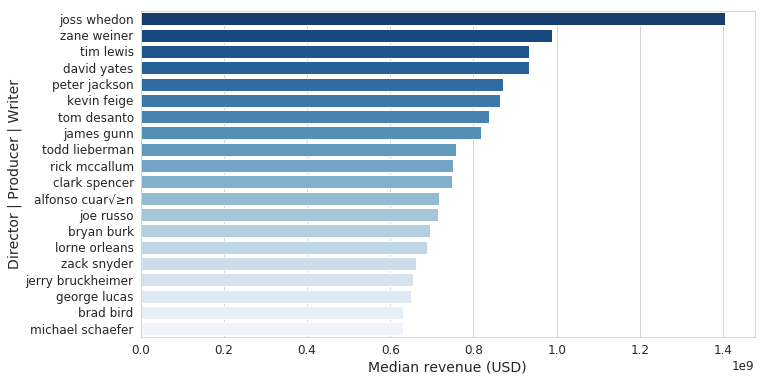

In [297]:
crew_train_df = get_revenue_stats(train, crew_train, 'median')[:20]

plt.figure(figsize=(11,6))
g = sns.barplot(x='revenue', y=[name[14:] for name in crew_train_df.index], data=crew_train_df,
                palette='Blues_r')
plt.xlabel('Median revenue (USD)')
plt.ylabel('Director | Producer | Writer')
plt.show()

In [298]:
crew_keep = top_col(pd.concat([crew_train, crew_test], axis=0), 0)
crew_train_drop = list(set(crew_train.columns) - set(crew_keep))
crew_test_drop = list(set(crew_test.columns) - set(crew_keep))  

train.drop(crew_train_drop, axis=1, inplace=True)
test.drop(crew_test_drop, axis=1, inplace=True)

Some people have been 2 or 3 roles of director, producer, and writer during their career. 

In [299]:
print('Total count of distinct Director:', len(set(df['crew_director'])))
print('Count of people who has been Director & Producer:', len(set(df['crew_director']) & set(df['crew_producer'])))
print('Count of people who has been Director & Writer:',len(set(df['crew_director']) & set(df['crew_writer'])))

Total count of distinct Director: 2469
Count of people who has been Director & Producer: 265
Count of people who has been Director & Writer: 529


### 11. Movie languages

There is also information regarding languages for movies in the dataset. Let's see what we can observe from them.<br>
First, let's look at the "original language" of the movies.

In [300]:
orig_lang_train = get_dummy_dict_col(train, 'original_language')
orig_lang_test = get_dummy_dict_col(test, 'original_language')

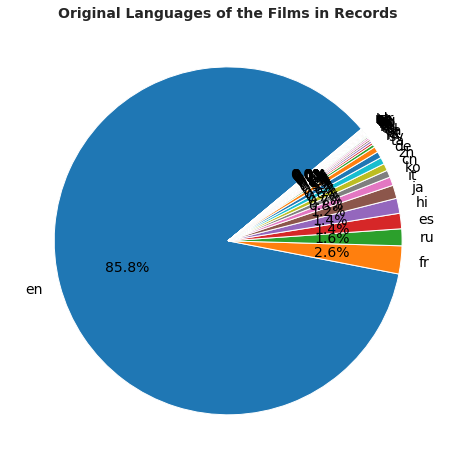

In [301]:
_, texts, autotexts = plt.pie(train['original_language'].value_counts(),
                              labels=train['original_language'].value_counts().index,
                              autopct='%1.1f%%', 
                              startangle=40,
                              colors=sns.color_palette('tab10'),
                              textprops={'fontsize':14})
for text in texts:
    text.set_color('black')
    
for autotxt in autotexts:
    autotxt.set_color('black')
    
plt.title('Original Languages of the Films in Records',fontsize=14, weight='bold')
plt.show()

***
- More than 85% of the films are made with English as the original language. 
- The runner-up is French, which is about 2.6%. 
- Because the data distribution is so imbalanced, this information is not likely to be very helpful in determining how much revenue a film would make.
***

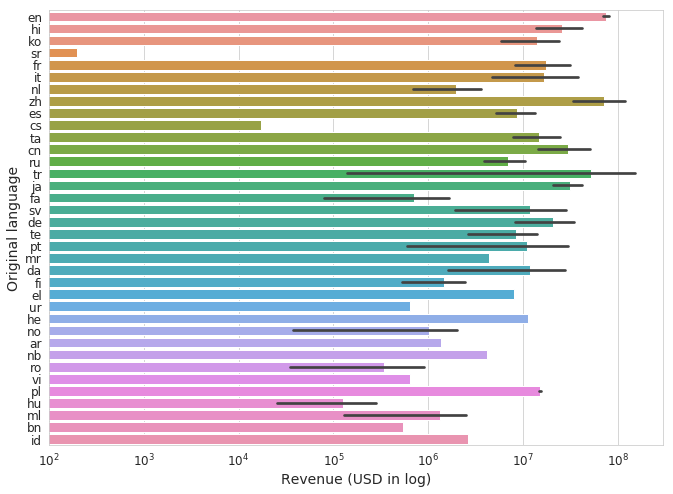

In [302]:
plt.figure(figsize=(11,8))
sns.barplot(x='revenue', y='original_language', data=train)
plt.xlabel('Revenue (USD in log)')
plt.ylabel('Original language')
plt.xscale('log')
plt.show()

***
- Even though movies based on English are majority, **movies based on some other languages are generating just as much of average revenues**, e.g. Chinese (zh) and Turkish (tr), albeit that the the later has a much wider range of variation (note that x-axis is in log-scale).
- This is likely due to the fact that English is a international language, and movie industry and film production in English-speaking countries started much earlier compared to other countries. As a result, they created more revenues over the years.
***

In [303]:
orig_lang_common = list(set(orig_lang_train.columns) & set(orig_lang_test.columns))
orig_lang_train = orig_lang_train[orig_lang_common]
orig_lang_test = orig_lang_test[orig_lang_common]

train = pd.concat([train, orig_lang_train], axis=1)
test = pd.concat([test, orig_lang_test], axis=1)

In [304]:
orig_lang_keep = top_col(pd.concat([orig_lang_train, orig_lang_test], axis=0),5)
orig_lang_train_drop = list(set(orig_lang_train.columns) - set(orig_lang_keep))
orig_lang_test_drop = list(set(orig_lang_test.columns) - set(orig_lang_keep))  

train.drop(orig_lang_train_drop, axis=1, inplace=True)
test.drop(orig_lang_test_drop, axis=1, inplace=True)

Another relevant feature is the "spoken_languages," i.e number of languages available for the movie.

In [305]:
for df in [train, test]:
    df['spoken_languages'] = df['spoken_languages'].apply(lambda x: extract_text(x, 'name'))
    df['num_languages'] = df['spoken_languages'].fillna('').apply(lambda x: len(x))
    df.drop('spoken_languages', axis=1, inplace=True)

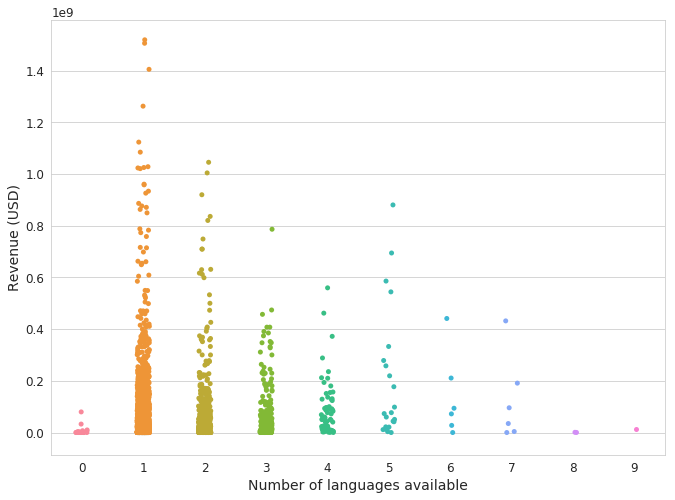

In [306]:
sns.stripplot(x='num_languages', y='revenue', data=train)
plt.xlabel('Number of languages available')
plt.ylabel('Revenue (USD)')
plt.show()

***
- It seems like 1-3 total available movie languages suggest a relatively high revenue rather than more languages.
- There are some data points at "0", which I am assuming they actually represents missing data that may nevery been reported. 
- As a result, I will replace those records with 0 spoken languages with 1.
***

In [307]:
for df in [train, test]:
    df['num_languages'] = np.where(df['num_languages']<1,1,df['num_languages'])

### 12. Movie popularity

With the data scrapped from IMDb, let's check whether there are relationships between budget or revenue with the movie popularity (i.e. votes).<br>

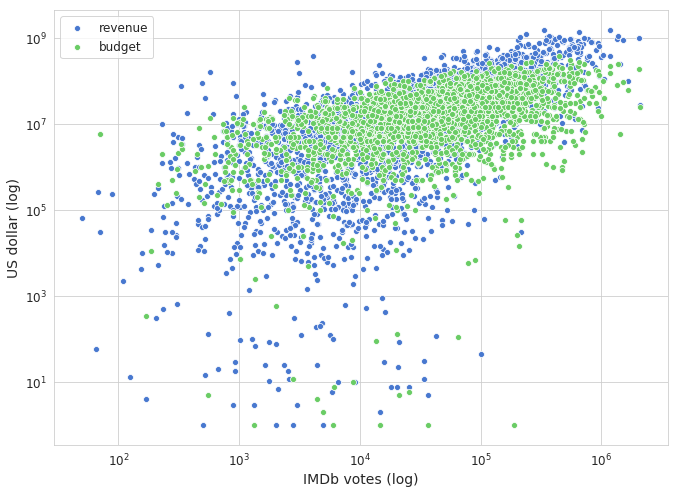

In [308]:
sns.scatterplot(x='votes_imdb', y='revenue', data=train, label='revenue')
sns.scatterplot(x='votes_imdb', y='budget', data=train, label='budget')
plt.xlabel('IMDb votes (log)')
plt.ylabel('US dollar (log)')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)
plt.show()

Finally, let's remove features that are useless for the prediction, such as "imdb_id", "original_title", "poster_path", "homepage'", etc.

In [309]:
for df in [train, test]:
    df.drop(['imdb_id','original_title', 'homepage','poster_path','status','budget_imdb','director_imdb','runtime_imdb'], axis=1, inplace=True)

## Linear regressor, Random Forest, and Gradient Boosting regressor

In [310]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

Build a simple function for cross-validation.

In [114]:
#Validation function
def rmse_cv(model, X, y, n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=100).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y.values,
                                    scoring="neg_mean_squared_error",
                                    cv=kf,
                                    verbose=0, 
                                    n_jobs=-1))
    return rmse

In [115]:
np.random.seed(100)
mask = np.random.rand(len(train))<1
train_df = train[mask]
eval_df = train[~mask]
test_df = test.copy()

Here is what the current train dataset looks like.

In [116]:
train_df.head()

,id,budget,genres,original_language,popularity,production_companies,runtime,Keywords,revenue,rating_imdb,...,production_companies_warner bros.,production_companies_paramount pictures,Keywords_murder,Keywords_independent film,Keywords_duringcreditsstinger,Keywords_based on novel,Keywords_woman director,log_revenue,log_budget,budget_to_runtime
0,1,14000000,[comedy],en,6.575393,"[paramount pictures, united artists, metro-gol...",93.0,"[time travel, sequel, hot tub, duringcreditsst...",12314651,5.1,...,0,1,0,0,1,0,0,16.326300,16.454568,150537.634409
1,2,40000000,"[comedy, drama, family, romance]",en,8.248895,[walt disney pictures],113.0,"[coronation, duty, marriage, falling in love]",95149435,5.8,...,0,0,0,0,0,0,0,18.370959,17.504390,353982.300885
2,3,3300000,[drama],en,64.299990,"[bold films, blumhouse productions, right of w...",105.0,"[jazz, obsession, conservatory, music teacher,...",13092000,8.5,...,0,0,0,0,0,0,0,16.387512,15.009433,31428.571429
3,4,1200000,"[thriller, drama]",hi,3.174936,[],122.0,"[mystery, bollywood, police corruption, crime,...",16000000,8.1,...,0,0,0,0,0,0,0,16.588099,13.997833,9836.065574
4,5,0,"[action, thriller]",ko,1.148070,[],118.0,[],3923970,5.8,...,0,0,0,0,0,0,0,15.182615,0.000000,0.000000


Split the train dataset into training data and evaluation data.

In [117]:
for df in [train_df, eval_df, test]:
    df[['release_year', 'release_month', 'release_dow']] = \
    df[['release_year', 'release_month', 'release_dow']].applymap(int)

In [118]:
drop_col = ['log_revenue','revenue','id','genres','production_companies','Keywords','original_language',
            'release_dow', #'release_month', 'release_year',
            'cast_name','crew_combined','crew_director','crew_producer','crew_writer']


In [119]:
X_train = train_df.drop(drop_col, axis=1)
y_train = train_df[['log_revenue']]
X_eval = eval_df.drop(drop_col, axis=1)
y_eval = eval_df[['log_revenue']]


X_test = test_df.drop(drop_col[2:], axis=1)


In [120]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f}".format(
                  np.sqrt(-results['mean_test_score'][candidate])))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

Get baseline results from basic regressors. Here I use Elastic Net, Random Forest regressor, and Gradient Boosting regressor.

1. Elastic Net

In [121]:
model_enet = ElasticNetCV(l1_ratio=0.5)

In [122]:
score = rmse_cv(model_enet, X_train, y_train)
print("Models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Models score: 2.6409 (0.1415)


2. Random Forest Regressor

In [123]:
model_rfr = RandomForestRegressor(n_jobs=-1)

In [124]:
score = rmse_cv(model_rfr, X_train, y_train)
print("Models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Models score: 2.1975 (0.1333)


3. Gradient Boosting Regressor

In [125]:
gbr_params = {'n_estimators': 100, 
              'max_depth': 4, 
              'min_samples_split': 2,
              'min_samples_leaf':2,
              'learning_rate': 0.1,
              'subsample':0.2,
              'loss':'huber',
             }

model_gbr = GradientBoostingRegressor(**gbr_params)

In [126]:
score = rmse_cv(model_gbr, X_train, y_train)
print("Models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Models score: 2.0948 (0.1016)


*** 
- It appears Gradient Boosting regressor gives the best CV result.
***

## LightGBM

Now let's try to model the data with a powerful Gradient Boosting model -- LightGBM.<br>
I will first use *RandomSearchCV* to narrow down the range for hyperparameter tuning.

In [127]:
lgb_params = {'max_depth':[3,4,5,6],
              'num_leaves':np.arange(2,40,2),
              'n_estimators':np.arange(100,400,10),
              'min_split_gain':np.linspace(0.1,1,10),
              'min_child_samples':np.arange(1,10,1),
              'learning_rate':[0.005,0.01,0.02],
              'reg_alpha':[0.005,0.01,0.05,0.1],
              'feature_fraction':np.linspace(0.1,1,10),
              'bagging_freq':np.arange(2,8,1),
              'bagging_fraction':np.linspace(0.1,1,10)
             }

n_iter = 50
lgb_random_search = RandomizedSearchCV(LGBMRegressor(), 
                                       param_distributions=lgb_params,
                                       n_iter=n_iter, 
                                       cv=5, 
                                       scoring='neg_mean_squared_error', 
                                       n_jobs=-1,
                                       iid=False)


In [128]:
lgb_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid=False, n_iter=50, n_jobs=-1,
          param_distributions={'max_depth': [3, 4, 5, 6], 'num_leaves': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38]), 'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 3...([2, 3, 4, 5, 6, 7]), 'bagging_fraction': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
          pre_dispatch='2*n_

In [129]:
report(lgb_random_search.cv_results_)

Model with rank: 1
Mean validation score: 2.010
Parameters: {'reg_alpha': 0.05, 'num_leaves': 30, 'n_estimators': 390, 'min_split_gain': 0.6, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.02, 'feature_fraction': 0.4, 'bagging_freq': 6, 'bagging_fraction': 1.0}

Model with rank: 2
Mean validation score: 2.025
Parameters: {'reg_alpha': 0.01, 'num_leaves': 36, 'n_estimators': 390, 'min_split_gain': 0.1, 'min_child_samples': 2, 'max_depth': 5, 'learning_rate': 0.02, 'feature_fraction': 0.4, 'bagging_freq': 3, 'bagging_fraction': 0.30000000000000004}

Model with rank: 3
Mean validation score: 2.035
Parameters: {'reg_alpha': 0.1, 'num_leaves': 14, 'n_estimators': 370, 'min_split_gain': 0.1, 'min_child_samples': 8, 'max_depth': 3, 'learning_rate': 0.02, 'feature_fraction': 0.5, 'bagging_freq': 3, 'bagging_fraction': 0.4}



In [131]:
lgb_params_grid = {'max_depth':[5],
                   'num_leaves':[28,30,32],
                   'n_estimators':[390],
                   'min_split_gain':[0.1, 0.3, 0.6],
                   'min_child_samples':[3,4,5],
                   'learning_rate':[0.02],
                   'reg_alpha':[0.05],
                   'feature_fraction':[0.4],
                   'bagging_freq':[4,6],
                   'bagging_fraction':[0.3,0.6,1]
                  }

lgb_grid_search = GridSearchCV(LGBMRegressor(), 
                               param_grid=lgb_params_grid,
                               cv=5, 
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               iid=False)


In [132]:
lgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': [5], 'num_leaves': [28, 30, 32], 'n_estimators': [390], 'min_split_gain': [0.1, 0.3, 0.6], 'min_child_samples': [3, 4, 5], 'learning_rate': [0.02], 'reg_alpha': [0.05], 'feature_fraction': [0.4], 'bagging_freq': [4, 6], 'bagging_fraction': [0.3, 0.6, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [133]:
report(lgb_grid_search.cv_results_)

Model with rank: 1
Mean validation score: 1.998
Parameters: {'bagging_fraction': 1, 'bagging_freq': 4, 'feature_fraction': 0.4, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_samples': 5, 'min_split_gain': 0.6, 'n_estimators': 390, 'num_leaves': 30, 'reg_alpha': 0.05}

Model with rank: 1
Mean validation score: 1.998
Parameters: {'bagging_fraction': 1, 'bagging_freq': 6, 'feature_fraction': 0.4, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_samples': 5, 'min_split_gain': 0.6, 'n_estimators': 390, 'num_leaves': 30, 'reg_alpha': 0.05}

Model with rank: 3
Mean validation score: 1.999
Parameters: {'bagging_fraction': 1, 'bagging_freq': 4, 'feature_fraction': 0.4, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_samples': 5, 'min_split_gain': 0.3, 'n_estimators': 390, 'num_leaves': 32, 'reg_alpha': 0.05}

Model with rank: 3
Mean validation score: 1.999
Parameters: {'bagging_fraction': 1, 'bagging_freq': 6, 'feature_fraction': 0.4, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_sam

In [154]:
model_lgb = LGBMRegressor(**lgb_grid_search.best_params_, n_jobs=-1)
model_lgb.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=1, bagging_freq=4, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
       importance_type='split', learning_rate=0.02, max_depth=5,
       min_child_samples=5, min_child_weight=0.001, min_split_gain=0.6,
       n_estimators=390, n_jobs=-1, num_leaves=30, objective=None,
       random_state=None, reg_alpha=0.05, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

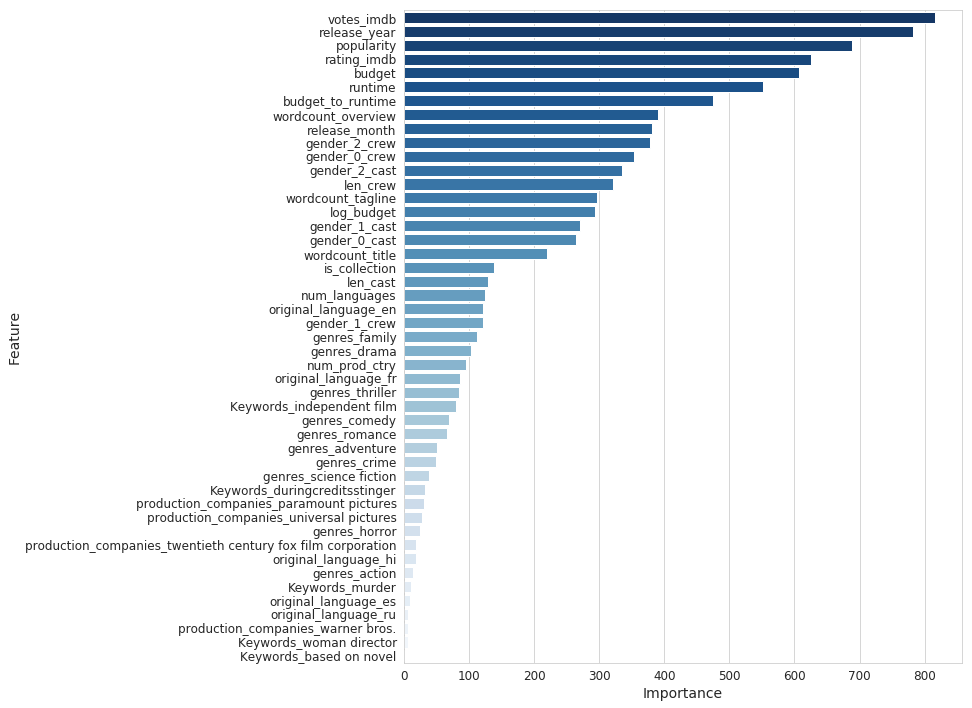

In [155]:
feat_imp = pd.DataFrame([X_train.columns, model_lgb.feature_importances_])
feat_imp = feat_imp.T
feat_imp.columns = ['Feature', 'Importance']
feat_imp = feat_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,12))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='Blues_r')
plt.show()

In [139]:
result = model_lgb.predict(X_test)
lgb_result = np.expm1(result)

**Submission score: 1.94553**
<br><br>

## XGBoost regressor

Next, I will try to use another powerful Gradient Boosting model -- XGBoost.<br>
Again, the search for optimal hyperparameters will begin with *RandomSerachCV* followed by *GridSearch* for fine-tuning.

In [140]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [142]:
xgb_params = {#'objective': 'reg:linear', 
              'max_depth': [3,4,5,6], 
              'learning_rate': [0.005,0.01,0.05,0.1],  
              'n_estimators': [2000],
              'colsample_bytree': np.linspace(0.4,1,7),
              'subsample': np.linspace(0.4,1,7),
              'min_child_weight':np.arange(0.1,1,10),
              'reg_alpha': [0.005,0.01,0.05,0.1],
              'gamma': [10,20,30],
              'scale_pos_weight': [0.1,0.5,1]
              }


n_iter = 20
xgb_random_search = RandomizedSearchCV(XGBRegressor(), 
                                       param_distributions=xgb_params,
                                       n_iter=n_iter, 
                                       cv=5, 
                                       scoring='neg_mean_squared_error', 
                                       n_jobs=-1,
                                       iid=False)


In [143]:
xgb_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid=False, n_iter=20, n_jobs=-1,
          param_distributions={'max_depth': [3, 4, 5, 6], 'learning_rate': [0.005, 0.01, 0.05, 0.1], 'n_estimators': [2000], 'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'subsample': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'min_child_weight': array([0.1]), 'reg_alpha': [0.005, 0.01, 0.05, 0.1], 'gamma': [10, 20, 30], 'scale_pos_weight': [0.1, 0.5, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
    

In [144]:
report(xgb_random_search.cv_results_)

Model with rank: 1
Mean validation score: 2.007
Parameters: {'subsample': 0.8999999999999999, 'scale_pos_weight': 0.1, 'reg_alpha': 0.005, 'n_estimators': 2000, 'min_child_weight': 0.1, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 30, 'colsample_bytree': 0.5}

Model with rank: 2
Mean validation score: 2.014
Parameters: {'subsample': 0.7, 'scale_pos_weight': 0.1, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 0.1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 30, 'colsample_bytree': 0.7}

Model with rank: 3
Mean validation score: 2.015
Parameters: {'subsample': 0.5, 'scale_pos_weight': 0.5, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 0.1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 10, 'colsample_bytree': 0.7}



In [145]:
xgb_params_grid = {#'objective': 'reg:linear', 
                   'max_depth': [4],              
                   'learning_rate': [0.01],  
                   'n_estimators': [2000],
                   'colsample_bytree': [0.5,0.7],
                   'subsample': [0.7,0.8,0.9],
                   'min_child_weight':[0.1],
                   'reg_alpha': [0.01],
                   'gamma': [20,30],
                   'scale_pos_weight': [0.1,0.4,0.8]
                  }


xgb_grid_search = GridSearchCV(XGBRegressor(), 
                               param_grid=xgb_params_grid,
                               cv=5, 
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               iid=False)


In [146]:
xgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': [4], 'learning_rate': [0.01], 'n_estimators': [2000], 'colsample_bytree': [0.5, 0.7], 'subsample': [0.7, 0.8, 0.9], 'min_child_weight': [0.1], 'reg_alpha': [0.01], 'gamma': [20, 30], 'scale_pos_weight': [0.1, 0.4, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [147]:
report(xgb_grid_search.cv_results_)

Model with rank: 1
Mean validation score: 1.999
Parameters: {'colsample_bytree': 0.5, 'gamma': 20, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 0.1, 'n_estimators': 2000, 'reg_alpha': 0.01, 'scale_pos_weight': 0.1, 'subsample': 0.9}

Model with rank: 1
Mean validation score: 1.999
Parameters: {'colsample_bytree': 0.5, 'gamma': 20, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 0.1, 'n_estimators': 2000, 'reg_alpha': 0.01, 'scale_pos_weight': 0.4, 'subsample': 0.9}

Model with rank: 1
Mean validation score: 1.999
Parameters: {'colsample_bytree': 0.5, 'gamma': 20, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 0.1, 'n_estimators': 2000, 'reg_alpha': 0.01, 'scale_pos_weight': 0.8, 'subsample': 0.9}



In [156]:
model_xgb = XGBRegressor(**xgb_grid_search.best_params_, n_jobs=-1)

In [157]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=20, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=0.1, missing=None, n_estimators=2000, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=0.1, seed=None,
       silent=True, subsample=0.9)

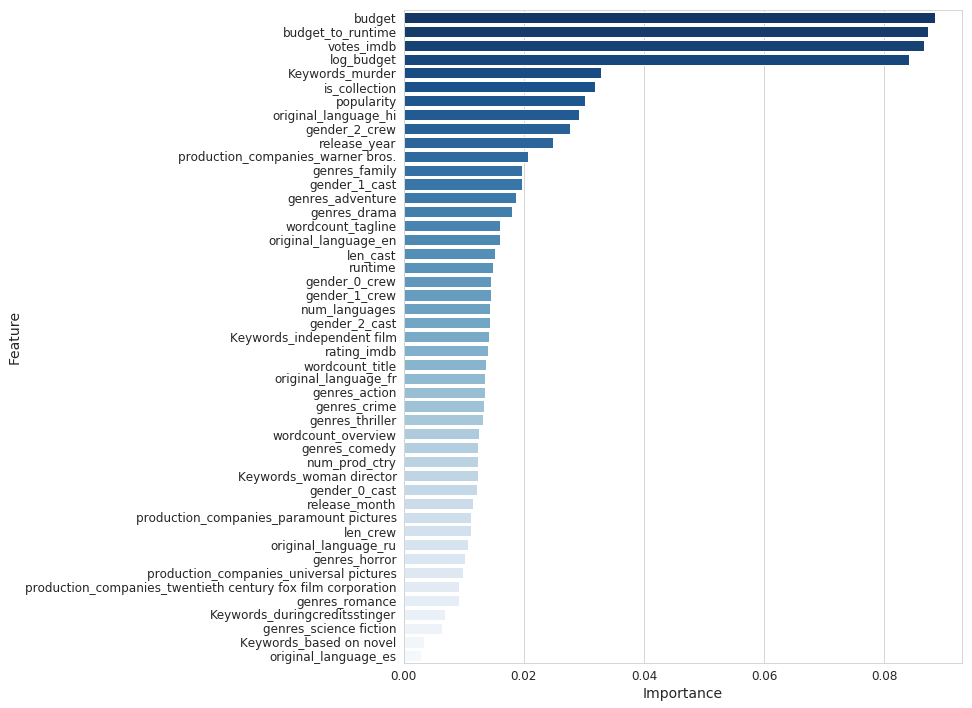

In [158]:
feat_imp = pd.DataFrame([X_train.columns, model_xgb.feature_importances_])
feat_imp = feat_imp.T
feat_imp.columns = ['Feature', 'Importance']
feat_imp = feat_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,12))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='Blues_r')
plt.show()

In [159]:
result = model_xgb.predict(X_test)
xgb_result = np.expm1(result)

**Submission score: 1.97247**
<br><br>

## Stacking LightGBM & XGBoost models

In [169]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [170]:
model_lgb = LGBMRegressor(**lgb_grid_search.best_params_, n_jobs=-1)
model_xgb = XGBRegressor(**xgb_grid_search.best_params_, n_jobs=-1)

In [171]:
averaged_models = AveragingModels(models = (model_lgb, model_xgb))

score = rmse_cv(averaged_models, X_train, y_train)
print(" Averaged base models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

 Averaged base models score: 1.9880 (0.1218)


In [175]:
averaged_models.fit(X_train.values, y_train.values)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AveragingModels(models=(LGBMRegressor(bagging_fraction=1, bagging_freq=4, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
       importance_type='split', learning_rate=0.02, max_depth=5,
       min_child_samples=5, min_child_weight=0.001, min_split_gain=0.6,
       n_esti...  reg_alpha=0.01, reg_lambda=1, scale_pos_weight=0.1, seed=None,
       silent=True, subsample=0.9)))

In [173]:
result = averaged_models.predict(X_test.values)
avg_result = np.expm1(result)

**Submission score: 1.94524**<br><br>

## Stacking LightGBM & XGBoost models with Neural Network as metal model
I am curious to see whether we can further improve the prediction by stacking LightGBM & XGBoost with an additional metal model, . <br>The choice of metal model is based on a 3-hidden layer Neural Network along with some degree of regularization (e.g. L1, early stopping). 

In [176]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
from keras import Model
from keras.layers import Input, Dense, Activation, regularizers
from keras.callbacks import EarlyStopping
from keras.models import clone_model

Using TensorFlow backend.


In [177]:
early_stopping = EarlyStopping(patience=10)
EPOCHS = 500
BATCH_SIZE = 500

In [178]:
class StackingAveragedModels_NN(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone_model(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=100)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):

            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.values[train_index], y.values.squeeze()[train_index])
                y_pred = instance.predict(X.values[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Meta-model use the out-of-fold predictions as new feature
        out_of_fold_predictions = StandardScaler().fit_transform(out_of_fold_predictions)
        self.meta_model_.compile(loss='mean_squared_error',
                                 optimizer=keras.optimizers.Adam(lr=0.001),
                                 metrics=['mean_squared_error'])
        self.meta_model_.fit(out_of_fold_predictions, y,
                             validation_split = 0.2,
                             epochs=EPOCHS,
                             shuffle=True,
                             verbose=1,
                             callbacks=[early_stopping])
        return self
   
    # Do the predictions using all base models on the test data 
    # and use the averaged predictions as the input features for meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        meta_features = StandardScaler().fit_transform(meta_features)
        return self.meta_model_.predict(meta_features)

In [179]:
kernel_reg = regularizers.l1(1e-3)

main_input = Input(shape=(2,), name='main_input')

layer0 = Dense(256, kernel_regularizer=kernel_reg)(main_input)
layer0 = Activation('relu')(layer0)

layer1 = Dense(256, kernel_regularizer=kernel_reg)(layer0)
layer1 = Activation('relu')(layer1)

layer2 = Dense(256, kernel_regularizer=kernel_reg)(layer1)
layer2 = Activation('relu')(layer2)

main_output = Dense(1, name='main_output')(layer2)

model_nn = Model(inputs=main_input, outputs=main_output)

model_nn.compile(loss='mean_squared_error',
                 optimizer=keras.optimizers.Adam(lr=0.001),
                 metrics=['mean_squared_error'])

Instructions for updating:
Colocations handled automatically by placer.


In [180]:
model_lgb = LGBMRegressor(**lgb_grid_search.best_params_, n_jobs=-1)
model_xgb = XGBRegressor(**xgb_grid_search.best_params_, n_jobs=-1)

In [181]:
stacked_averaged_models = StackingAveragedModels_NN(base_models = [model_lgb, model_xgb],
                                                    meta_model =  model_nn)

In [182]:
stacked_averaged_models.fit(X_train, y_train)

Instructions for updating:
Use tf.cast instead.
Train on 2400 samples, validate on 600 samples
Epoch 1/500
2400/2400 [==============================] - 1s 218us/step - loss: 84.1143 - mean_squared_error: 78.3522 - val_loss: 10.8129 - val_mean_squared_error: 6.0301
Epoch 2/500
2400/2400 [==============================] - 0s 61us/step - loss: 9.1322 - mean_squared_error: 4.6621 - val_loss: 7.5657 - val_mean_squared_error: 3.3399
Epoch 3/500
2400/2400 [==============================] - 0s 61us/step - loss: 8.3457 - mean_squared_error: 4.2936 - val_loss: 7.1978 - val_mean_squared_error: 3.3128
Epoch 4/500
2400/2400 [==============================] - 0s 61us/step - loss: 8.2511 - mean_squared_error: 4.5088 - val_loss: 7.3454 - val_mean_squared_error: 3.7411
Epoch 5/500
2400/2400 [==============================] - 0s 61us/step - loss: 7.8234 - mean_squared_error: 4.3436 - val_loss: 7.5198 - val_mean_squared_error: 4.1597
Epoch 6/500
2400/2400 [==============================] - 0s 61us/step -

2400/2400 [==============================] - 0s 61us/step - loss: 4.8237 - mean_squared_error: 4.2851 - val_loss: 3.8250 - val_mean_squared_error: 3.2947
Epoch 49/500
2400/2400 [==============================] - 0s 61us/step - loss: 4.8808 - mean_squared_error: 4.3585 - val_loss: 3.9706 - val_mean_squared_error: 3.4627
Epoch 50/500
2400/2400 [==============================] - 0s 61us/step - loss: 4.8049 - mean_squared_error: 4.2962 - val_loss: 4.0408 - val_mean_squared_error: 3.5444
Epoch 51/500
2400/2400 [==============================] - 0s 61us/step - loss: 4.7216 - mean_squared_error: 4.2271 - val_loss: 3.7980 - val_mean_squared_error: 3.3075
Epoch 52/500
2400/2400 [==============================] - 0s 61us/step - loss: 4.7378 - mean_squared_error: 4.2546 - val_loss: 3.8668 - val_mean_squared_error: 3.3943
Epoch 53/500
2400/2400 [==============================] - 0s 60us/step - loss: 4.7808 - mean_squared_error: 4.3087 - val_loss: 3.8515 - val_mean_squared_error: 3.3849
Epoch 54/50

2400/2400 [==============================] - 0s 62us/step - loss: 4.4694 - mean_squared_error: 4.2416 - val_loss: 3.5565 - val_mean_squared_error: 3.3316
Epoch 98/500
2400/2400 [==============================] - 0s 60us/step - loss: 4.4057 - mean_squared_error: 4.1816 - val_loss: 3.6284 - val_mean_squared_error: 3.4067
Epoch 99/500
2400/2400 [==============================] - 0s 60us/step - loss: 4.4126 - mean_squared_error: 4.1909 - val_loss: 3.6733 - val_mean_squared_error: 3.4527
Epoch 100/500
2400/2400 [==============================] - 0s 60us/step - loss: 4.4951 - mean_squared_error: 4.2746 - val_loss: 3.8356 - val_mean_squared_error: 3.6174
Epoch 101/500
2400/2400 [==============================] - 0s 60us/step - loss: 4.3717 - mean_squared_error: 4.1559 - val_loss: 3.5028 - val_mean_squared_error: 3.2912
Epoch 102/500
2400/2400 [==============================] - 0s 60us/step - loss: 4.4387 - mean_squared_error: 4.2242 - val_loss: 3.5014 - val_mean_squared_error: 3.2908
Epoch 10

StackingAveragedModels_NN(base_models=[LGBMRegressor(bagging_fraction=1, bagging_freq=4, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
       importance_type='split', learning_rate=0.02, max_depth=5,
       min_child_samples=5, min_child_weight=0.001, min_split_gain=0.6,
       n...  reg_alpha=0.01, reg_lambda=1, scale_pos_weight=0.1, seed=None,
       silent=True, subsample=0.9)],
             meta_model=<keras.engine.training.Model object at 0x1481d0da0>,
             n_folds=5)

In [183]:
result = stacked_averaged_models.predict(X_test.values)

**Submission score: 1.96858**

***
Using NN as the meta model does not improve the model. This could be due to insufficient training data, which makes the NN not applicable to the unseen test data. A few techniques were adopted to prevent overfitting, such as regularizaion, early stopping, dropout, etc., but the benefits to this dataset are very limited.
***